In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from wordcloud import WordCloud
import warnings

warnings.filterwarnings('ignore')

In [2]:
# Load datasets
train_set = pd.read_csv('/kaggle/input/toxic-comment-dataset/train.csv')
test_set = pd.read_csv('/kaggle/input/toxic-comment-dataset/test.csv')
test_labels = pd.read_csv('/kaggle/input/toxic-comment-dataset/test_labels.csv')

# Remove test instances with -1 labels
test_set = test_set[test_labels.iloc[:, 1:].sum(axis=1) != -5]
test_labels = test_labels[test_labels.iloc[:, 1:].sum(axis=1) != -5]

# Check dataset structure
print("Training set shape:", train_set.shape)
print("Test set shape:", test_set.shape)

Training set shape: (159571, 8)
Test set shape: (153164, 2)


## Exploratory Data Analysis (EDA)

### 1. Class Distribution


Class distribution in training set:
toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


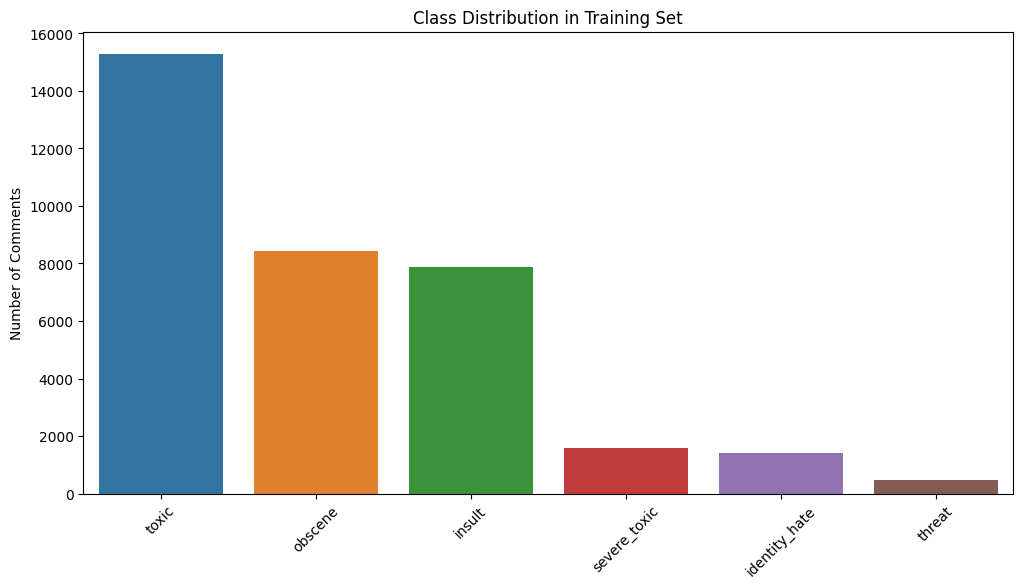

In [3]:
print("\nClass distribution in training set:")
class_dist = train_set.iloc[:, 2:].sum().sort_values(ascending=False)
print(class_dist)

plt.figure(figsize=(12, 6))
sns.barplot(x=class_dist.index, y=class_dist.values)
plt.title("Class Distribution in Training Set")
plt.xticks(rotation=45)
plt.ylabel("Number of Comments")
plt.show()

### 2. Correlation Heatmap

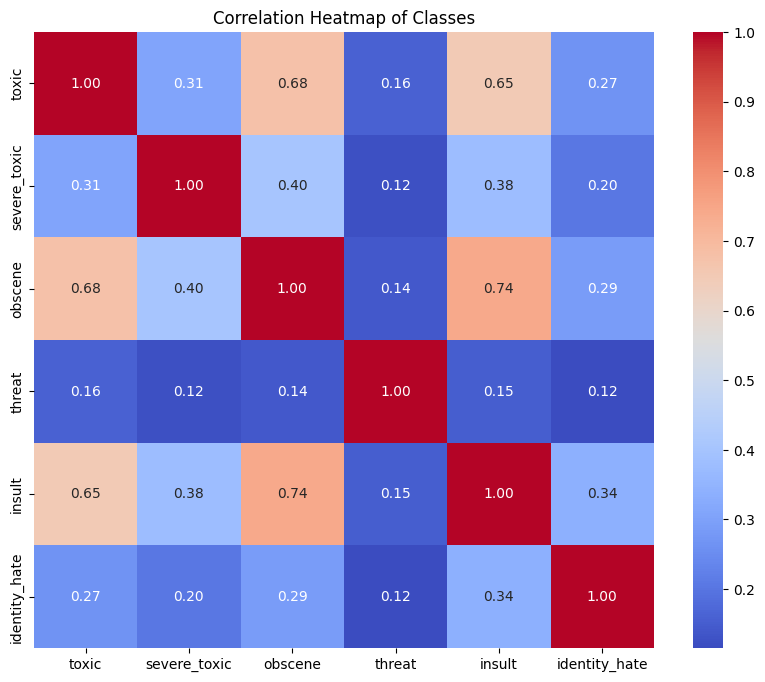

In [4]:
plt.figure(figsize=(10, 8))
sns.heatmap(train_set.iloc[:, 2:].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap of Classes")
plt.show()

### 3. Word Cloud

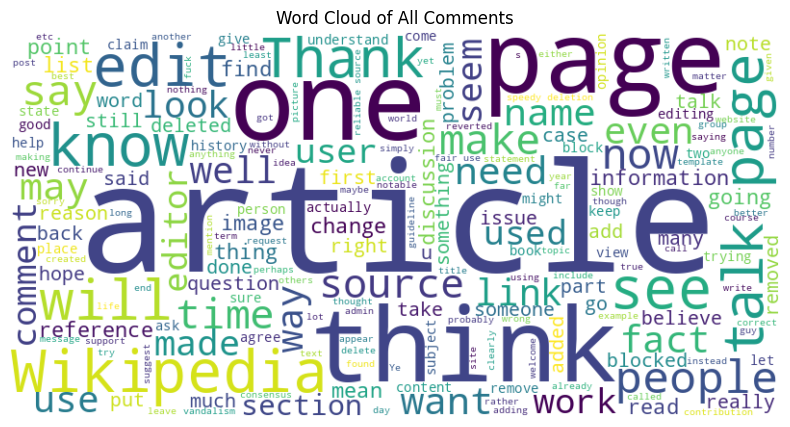

In [5]:
def create_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Word Cloud of All Comments")
    plt.show()

create_wordcloud(' '.join(train_set['comment_text']))

### 4. Comment Length Distribution

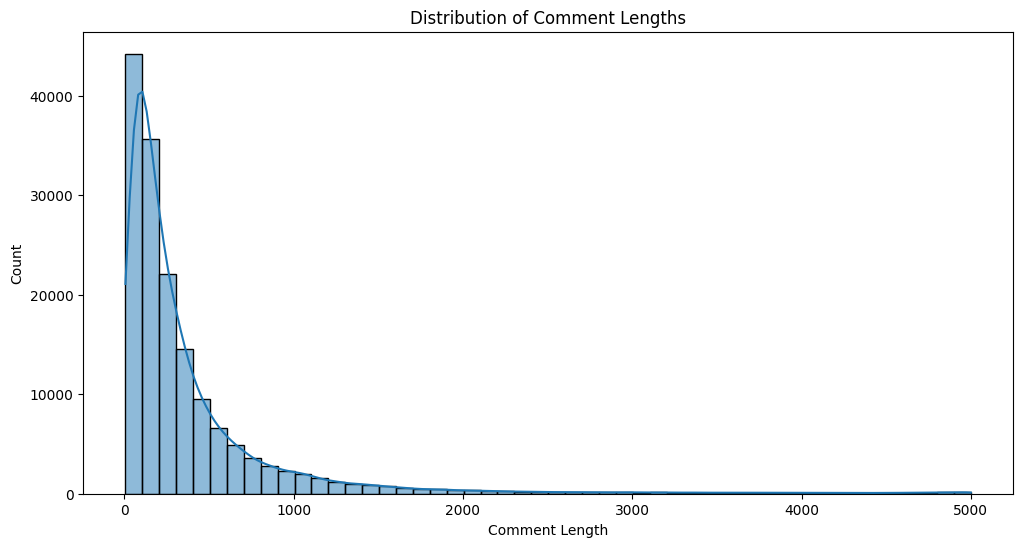


Comment Length Statistics:
count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_length, dtype: float64


In [6]:
train_set['comment_length'] = train_set['comment_text'].str.len()

plt.figure(figsize=(12, 6))
sns.histplot(data=train_set, x='comment_length', bins=50, kde=True)
plt.title("Distribution of Comment Lengths")
plt.xlabel("Comment Length")
plt.show()

print("\nComment Length Statistics:")
print(train_set['comment_length'].describe())

### 5. Multi-label Distribution

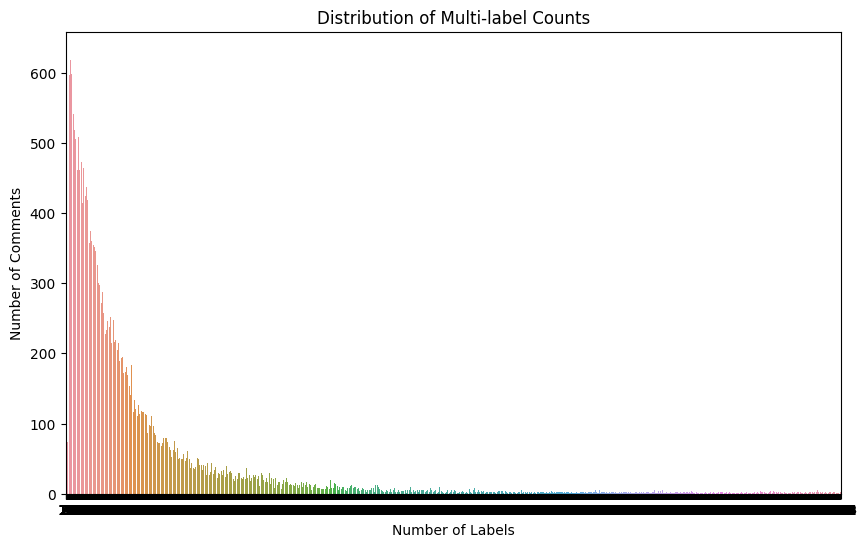

In [7]:
label_counts = train_set.iloc[:, 2:].sum(axis=1).value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Distribution of Multi-label Counts")
plt.xlabel("Number of Labels")
plt.ylabel("Number of Comments")
plt.show()

## Model Training and Evaluation

In [8]:
# Text preprocessing
def tokenize_text(text):
    tokens = str(text).lower().split()
    return [word for word in tokens if word.isalnum()]

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1),
                                   analyzer='word',
                                   tokenizer=tokenize_text,
                                   stop_words='english',
                                   strip_accents='unicode',
                                   use_idf=True, min_df=10)

X = tfidf_vectorizer.fit_transform(train_set['comment_text'].fillna(""))
y = train_set.iloc[:, 2:].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Definitions
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'MultinomialNB': MultinomialNB(),
    'Linear SVC': LinearSVC(random_state=42, max_iter=1000)
}

# Cross-validation and training
cv_scores = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train[:, 0], cv=5, scoring='f1_micro')
    cv_scores[name] = scores
    print(f"{name} CV Scores: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
    model.fit(X_train, y_train[:, 0])

# Evaluation on validation set
val_scores = {}
for name, model in models.items():
    y_pred = model.predict(X_val)
    report = classification_report(y_val[:, 0], y_pred, output_dict=True)
    val_scores[name] = report
    print(f"\n{name} Classification Report:")
    print(classification_report(y_val[:, 0], y_pred))

# Test set evaluation
X_test = tfidf_vectorizer.transform(test_set['comment_text'].fillna(""))
y_test = test_labels.iloc[:, 1:].values

best_model = models['Linear SVC']  # Choose the best model based on validation performance
y_test_pred = best_model.predict(X_test)

print("\nTest Set Evaluation:")
print(classification_report(y_test[:, 0], y_test_pred))

Logistic Regression CV Scores: 0.9459 (+/- 0.0019)
MultinomialNB CV Scores: 0.9397 (+/- 0.0017)
Linear SVC CV Scores: 0.9485 (+/- 0.0021)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     28859
           1       0.90      0.50      0.65      3056

    accuracy                           0.95     31915
   macro avg       0.92      0.75      0.81     31915
weighted avg       0.94      0.95      0.94     31915


MultinomialNB Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     28859
           1       0.92      0.41      0.57      3056

    accuracy                           0.94     31915
   macro avg       0.93      0.70      0.77     31915
weighted avg       0.94      0.94      0.93     31915


Linear SVC Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99   

## Model Comparison Table

Model Comparison Table:
                     CV F1-micro (mean)  CV F1-micro (std)  Validation F1-score  Validation Precision  Validation Recall
Model                                                                                                                   
Linear SVC                     0.948541           0.001040             0.946034              0.946864           0.950149
Logistic Regression            0.945925           0.000948             0.940213              0.944871           0.947047
MultinomialNB                  0.939650           0.000856             0.929576              0.938879           0.940122


<Figure size 1200x600 with 0 Axes>

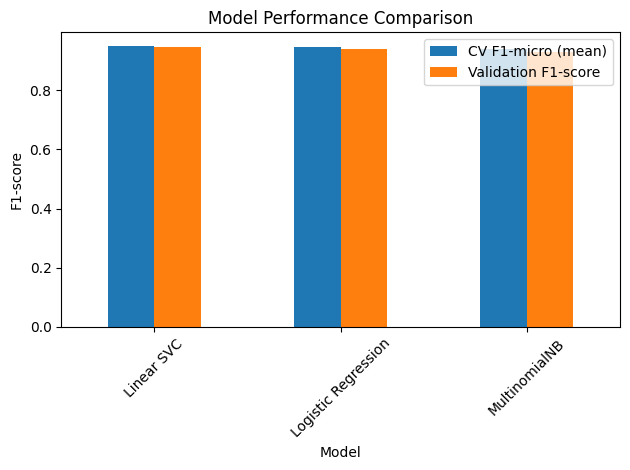

In [9]:
# Create a DataFrame for model comparison
comparison_data = []
for name in models.keys():
    comparison_data.append({
        'Model': name,
        'CV F1-micro (mean)': cv_scores[name].mean(),
        'CV F1-micro (std)': cv_scores[name].std(),
        'Validation F1-score': val_scores[name]['weighted avg']['f1-score'],
        'Validation Precision': val_scores[name]['weighted avg']['precision'],
        'Validation Recall': val_scores[name]['weighted avg']['recall']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.set_index('Model')
comparison_df = comparison_df.sort_values('Validation F1-score', ascending=False)

print("Model Comparison Table:")
print(comparison_df.to_string())

# Visualize model comparison
plt.figure(figsize=(12, 6))
comparison_df[['CV F1-micro (mean)', 'Validation F1-score']].plot(kind='bar')
plt.title("Model Performance Comparison")
plt.ylabel("F1-score")
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()
